In [1]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

In [2]:
import os.path
from itertools import chain, combinations
from typing import Dict, List, Tuple, Iterable, Any

import numpy as np
import pandas as pd
from gapstatistics.gapstatistics import GapStatistics
from clustering import AgglomerativeClusteringWrapper as AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.spatial.distance import jensenshannon, correlation, euclidean
from tqdm.contrib.concurrent import thread_map
import seaborn as sns

import config

In [3]:
import torch
from torch.distributions import kl_divergence
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta
from torch.distributions.dirichlet import Dirichlet
from ParameterizedModel.parameterized_model import Paremeterized_Model
from ParameterizedModel.utils.distribution_helpers import mean_std_to_beta_params

from ParameterizedModel.training import Trainer

In [4]:
from gradient_solver import construct_distance_matrix

In [5]:
import timeit

In [6]:
from IPython.display import display, Math, Latex

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [8]:
from scipy.spatial.distance import correlation

In [9]:
from gradient_solver import *

In [10]:
'''df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features()
df_observable_distances: pd.DataFrame = pd.read_excel(
    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
    index_col=0
)
features: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())

# Ensure that both datasets contain the same indices
valid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)
df_explainable = df_explainable.loc[valid_indices]
df_observable_distances = df_observable_distances.loc[valid_indices]'''

'df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features()\ndf_observable_distances: pd.DataFrame = pd.read_excel(\n    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",\n    index_col=0\n)\nfeatures: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())\n\n# Ensure that both datasets contain the same indices\nvalid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)\ndf_explainable = df_explainable.loc[valid_indices]\ndf_observable_distances = df_observable_distances.loc[valid_indices]'

In [11]:
##################
# Synthetic Data #
##################
individuals = 5
base_size = 10

#observation_data = np.random.normal(loc=0, scale=1, size=(base_size, 6))
'''explanation_data = np.random.uniform(0,1, size=(individuals, 11))
df_explainable = pd.DataFrame(explanation_data)
df_explainable.loc[:, 'Individual'] = [f'Individual_{i}' for i in df_explainable.index]
df_explainable.set_index('Individual', inplace=True)'''

df_explainable = pd.DataFrame({
    'Age': np.random.choice([0., 0.5, 1.], individuals),
    'Weight': np.random.uniform(0,1, size=individuals),
    'Is_a_Zebra': np.random.choice([0., 1.], individuals),
    'Loves_to_sleep': np.random.uniform(0,1, size=individuals),
    'Noise_1': np.random.uniform(0,1, size=individuals),
    'Noise_2': np.random.uniform(0,1, size=individuals),
    'Noise_3': np.random.uniform(0,1, size=individuals),
    'Noise_4': np.random.uniform(0,1, size=individuals),
    'Noise_5': np.random.uniform(0,1, size=individuals),
    'Individual': [f'Individual_{n}' for n in range(individuals)]
})
df_explainable.set_index('Individual', inplace=True)

explaining_features = np.array(list(df_explainable.columns))
individual_array = np.random.choice(df_explainable.index.unique(), size=base_size)

df_observable = pd.DataFrame({
    'Individual': individual_array,
})
df_observable.loc[:, 'unexplainable_1'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_2'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_3'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_4'] = np.random.normal(0,1, size=base_size)

df_observable.loc[:, 'if_zebra_then_age'] = (df_explainable.loc[individual_array, 'Is_a_Zebra'].values > 0.65) * df_explainable.loc[individual_array, 'Age'].values + (df_explainable.loc[individual_array, 'Is_a_Zebra'].values <= 0.65) * np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'explained_by_loves_to_sleep'] = df_explainable.loc[individual_array, 'Loves_to_sleep'].values #df_explainable.loc[individual_array, [1,2,3]].mean(axis=1).values #req_1 * df_explainable.loc[individual_array, 2].values + (1-req_1) * df_explainable.loc[individual_array, 3].values
df_observable.loc[:, 'Age_plus_Weight'] = df_explainable.loc[individual_array, 'Age'].values + df_explainable.loc[individual_array, 'Weight'].values

df_observable.set_index('Individual', inplace=True)
observed_features = list(df_observable.columns)

df_observable = df_observable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
df_explainable = df_explainable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

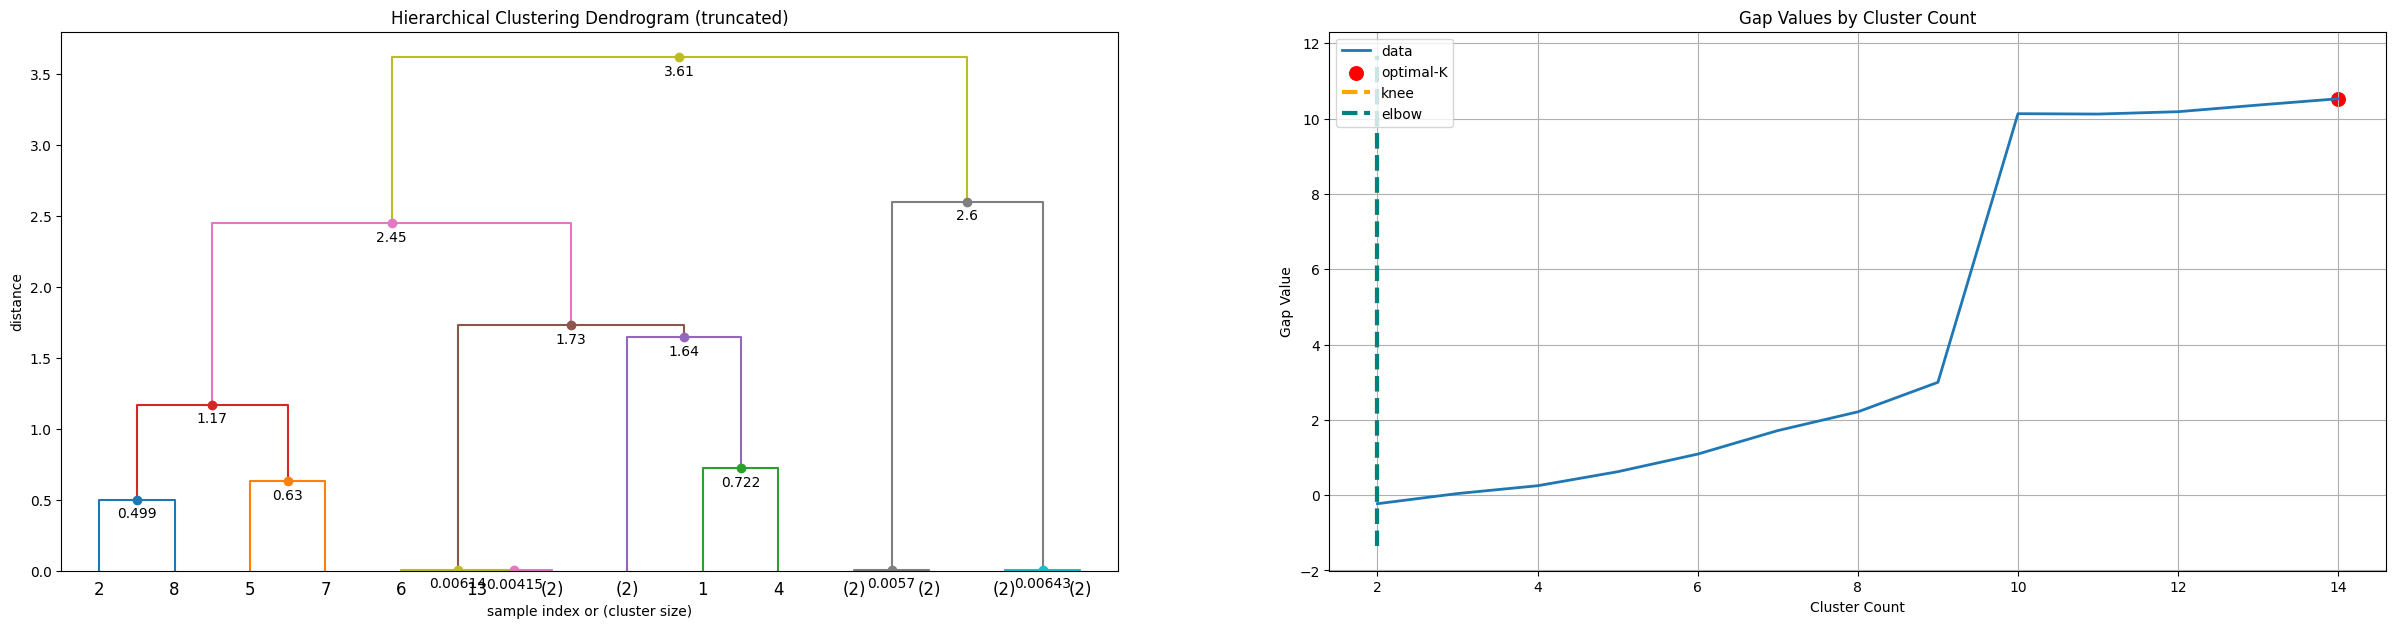

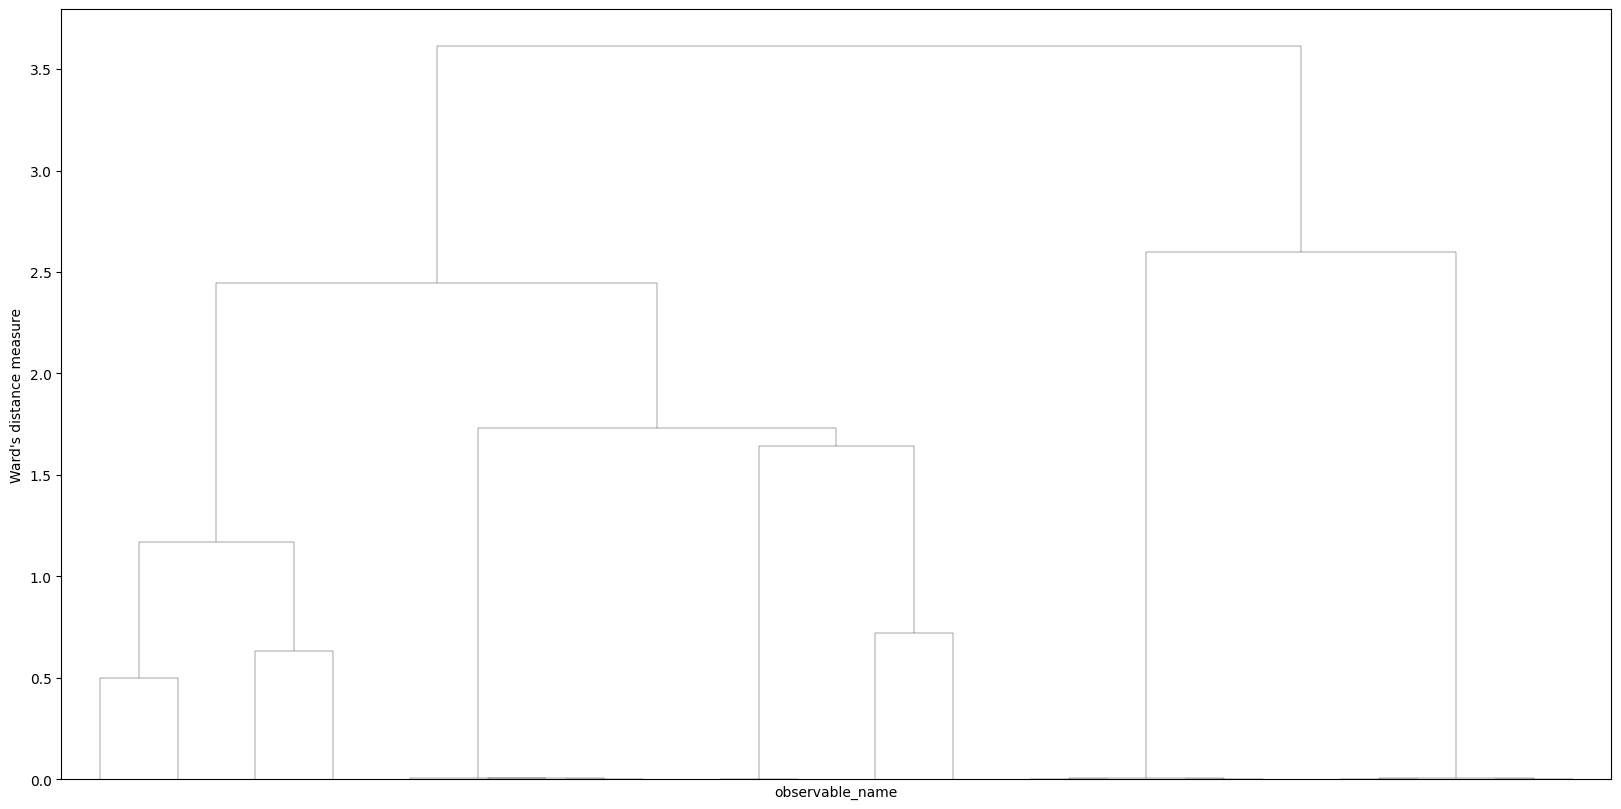

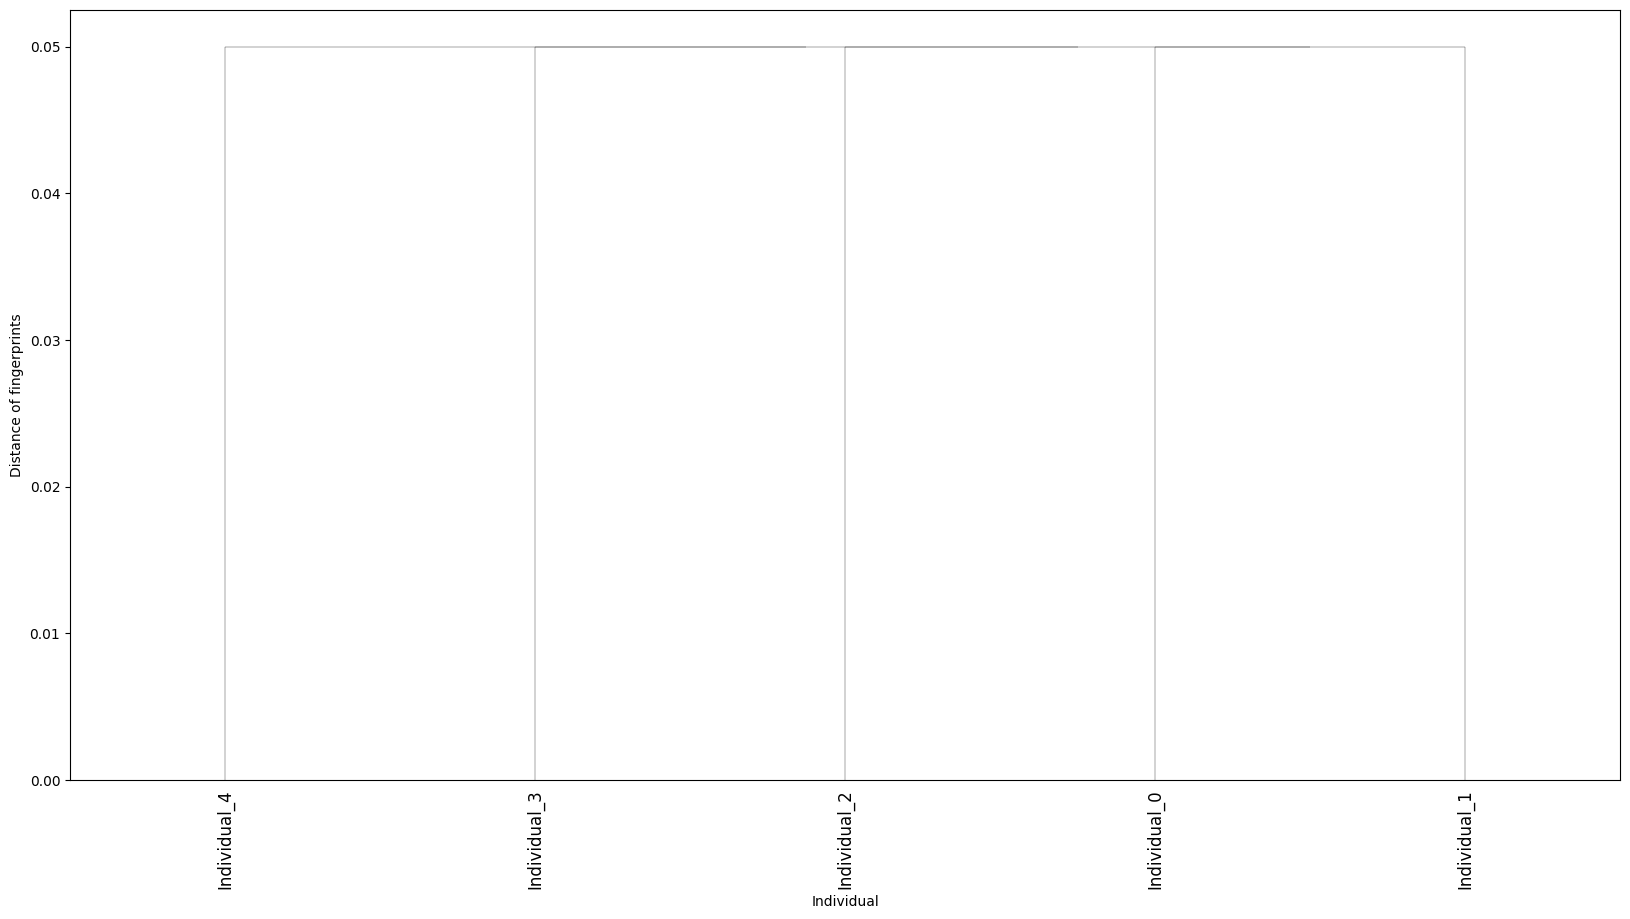

In [12]:
index_name = 'Individual'
my_linkage = 'ward' #'single'

from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

preparation_result = DataPreparator.prepare_data(
    use_config=False,
    df_observable=df_observable.reset_index(),
    df_explainable=df_explainable.reset_index(),
    distortion_mean=0.01,
    distortion_std=0.001,
    observed_features=observed_features,
    explaining_features=explaining_features,
    nn_imputation_k=10,
    group_name=index_name,
)
optimal_number_of_clusters = ClusteringApplier.draw_gap_statistic_plot(
    use_config=False, df_observable=preparation_result['observable_df'],
    observed_features=observed_features,
    gap_statistic_cluster_range=15,
    linkage='ward'
)
observable_patterns_result = ClusteringApplier.calculate_observable_patterns(
    use_config=False,
    df_observable_data=preparation_result['observable_df'],
    _n_clusters= 5, #optimal_number_of_clusters['n_clusters'],
    observable_name='observable_name',
    observable_feature_names=observed_features,
    plot_title='Name of the fingerprint plot',
    number_observable_patterns='auto',
    distance_measure_fingerprint='jensenshannon',
    group_name=index_name, 
    spiderplot_scaling='minmax',
    linkage=my_linkage
)

In [13]:
observable_patterns_result['spider_plots']

  0%|          | 0/502 [00:00<?, ?it/s]

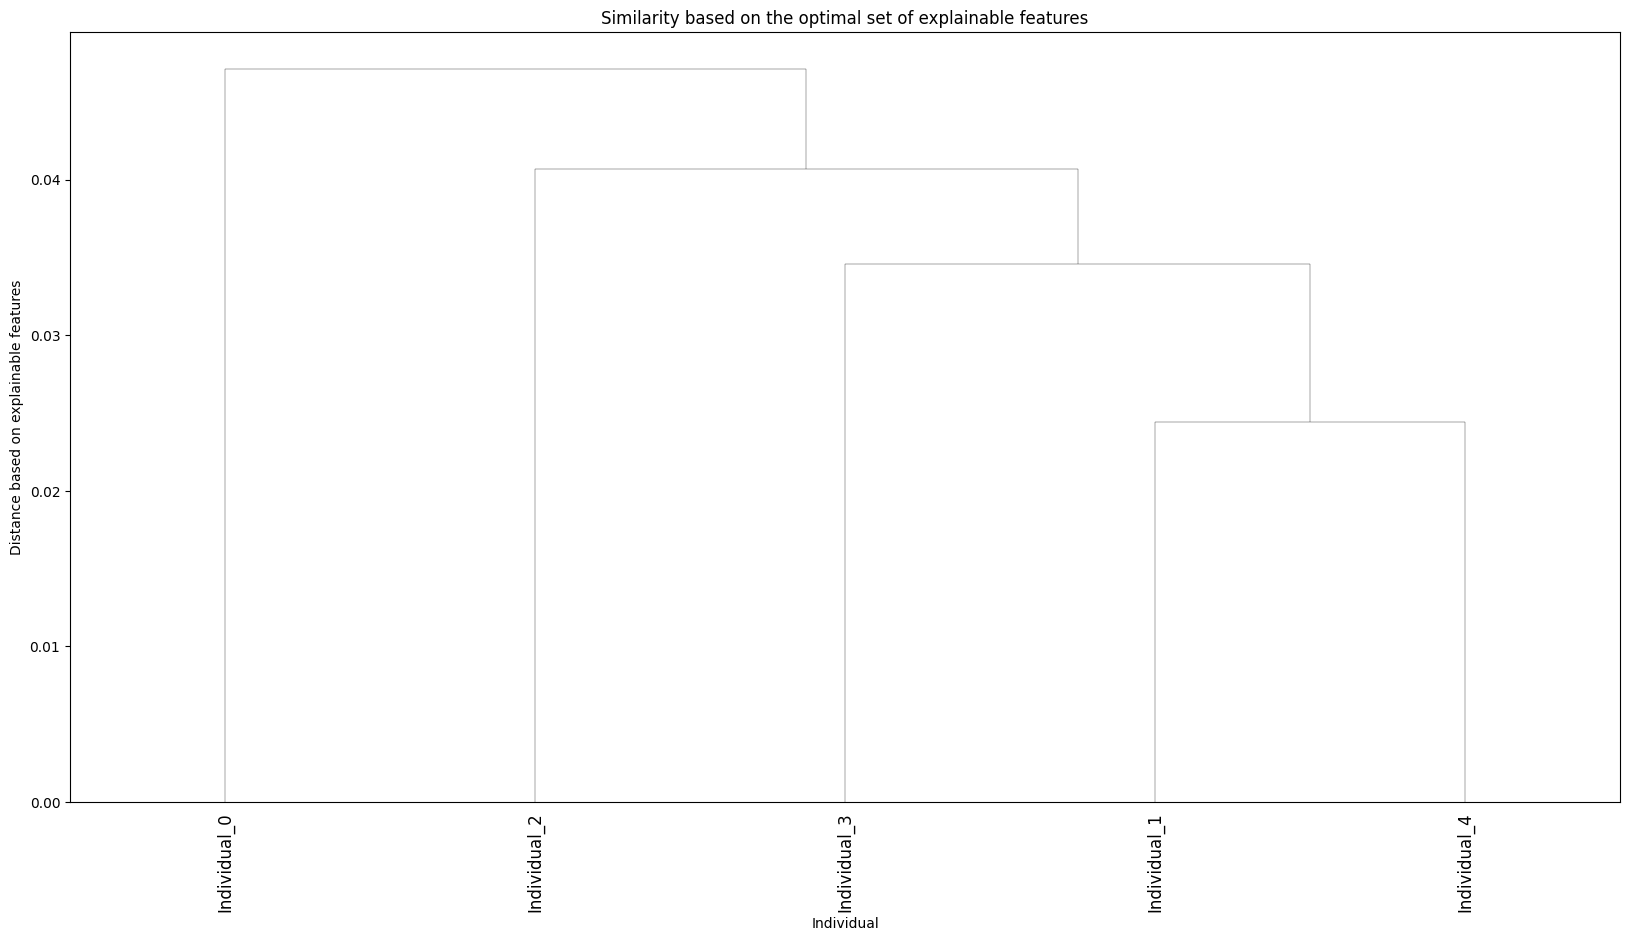

In [14]:
calculate_explainable_distances_result = ClusteringApplier.calculate_explainable_distances(
    use_config=False,
    df_explainable=preparation_result['explainable_df'].copy(),#.loc[:, q].apply(lambda x: np.nan_to_num(x)).set_index(index_name).loc[valid_indices],
    df_observable_distances=observable_patterns_result['pw_norm_dist'].copy(),#.loc[valid_indices, :].loc[:, valid_indices],
    explaining_features=explaining_features,
    method='exact',
    distance_measure='correlation',
    sparsity_parameter=0.01,
    max_num_threads=12,
    group_name=index_name
)

In [15]:
calculate_explainable_distances_result['overview_df']

,correlation,Age,Weight,Is_a_Zebra,Loves_to_sleep,Noise_1,Noise_2,Noise_3,Noise_4,Noise_5
0,0.85507,1,1,0,1,1,0,1,1,0


In [16]:
def ward_distance(x, y):
    # Compute the centroids of the two clusters
    centroid_x = torch.mean(x, dim=0)
    centroid_y = torch.mean(y, dim=0)

    # Compute the variance within each cluster
    var_x = torch.sum((x - centroid_x) ** 2) / (x.shape[0] - 1)
    var_y = torch.sum((y - centroid_y) ** 2) / (y.shape[0] - 1)

    # Compute the variance between the two clusters
    var_between = torch.sum((centroid_x - centroid_y) ** 2)

    # Compute the Ward distance
    return var_between + var_x + var_y

In [17]:
keystr = 'df_observable_data'

x = torch.tensor(observable_patterns_result[keystr].loc[:, observed_features].to_numpy())
y = torch.tensor(observable_patterns_result['df_cluster_median'].to_numpy())

alternative = ((x.unsqueeze(1) - y.unsqueeze(0)).pow(2).clamp(min=1e-20)).sum(2).sqrt()

vergleich = observable_patterns_result['df_observable_data'].pattern_type == alternative.argmin(dim=1).numpy() #torch.cdist(x, y).argmin(dim=1).numpy()
print(vergleich)
print(vergleich.sum() / observable_patterns_result[keystr].shape[0])

print(alternative.argmin(dim=1).numpy()[:23])
print(observable_patterns_result['df_observable_data'].pattern_type[:23].to_numpy())

0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
Name: pattern_type, dtype: bool
1.0
[0 0 1 3 0 1 4 1 1 2]
[0 0 1 3 0 1 4 1 1 2]


In [18]:
my_df = observable_patterns_result[keystr].copy()
my_df = my_df[my_df["oversampled"] == False]

In [19]:
my_df.loc[:, [index_name] + observed_features]

,Individual,unexplainable_1,unexplainable_2,unexplainable_3,unexplainable_4,if_zebra_then_age,explained_by_loves_to_sleep,Age_plus_Weight
0,Individual_3,0.009687,0.010927,0.012028,0.896346,0.880862,0.101731,0.900747
1,Individual_3,0.842834,0.399417,0.301833,1.010773,1.011286,0.099227,0.899786
2,Individual_2,0.453906,0.140325,0.591640,0.498258,0.009546,0.009485,0.553720
3,Individual_4,0.077563,0.799558,0.451976,0.010163,0.631525,0.974656,0.714491
4,Individual_3,0.818559,1.009419,0.590532,0.764829,0.940356,0.100947,0.899457
5,Individual_2,1.011211,0.706269,0.909113,0.050954,0.011308,0.009134,0.554464
6,Individual_1,0.414852,0.399872,0.451721,0.887369,0.133360,0.332071,1.008597
7,Individual_2,0.925305,0.149822,1.009792,0.315618,0.009519,0.011870,0.552944
8,Individual_2,0.079731,0.222090,0.681338,0.190486,0.008930,0.009654,0.553472
9,Individual_0,0.807863,0.213987,0.567607,0.431532,0.981843,1.009340,0.009745


In [20]:
df_observable_distances = observable_patterns_result['pw_norm_dist']
df_observable_distances.head()

Individual,Individual_0,Individual_1,Individual_2,Individual_3,Individual_4
Individual,,,,,
Individual_0,0.00,0.05,0.05,0.05,0.05
Individual_1,0.05,0.00,0.05,0.05,0.05
Individual_2,0.05,0.05,0.00,0.05,0.05
Individual_3,0.05,0.05,0.05,0.00,0.05
Individual_4,0.05,0.05,0.05,0.05,0.00


In [21]:
fingerprint_df = ClusteringApplier._calculate_fingerprints(
    df = my_df,
    group_name = index_name,
    use_config=False,
)

In [22]:
fingerprint_distanzen, normierte_fingerprint_distanzen = ClusteringApplier.calculate_pairwise_fingerprint_distances(
    df = fingerprint_df,
    distance = 'jensenshannon'
)

In [23]:
@torch.jit.script
def torch_relative_entropy(x:torch.Tensor, y:torch.Tensor) -> torch.Tensor:
    return (x * torch.log(x/y))

In [24]:
@torch.jit.script
def new_torch_matrix_jensenshannon(A:torch.Tensor) -> torch.Tensor:

    ########################################################################################
    ### Conversion of the jensenshannon distance from scipy.spatial.distance to pytorch. ###
    ########################################################################################

    """
    Compute the pairwise Jensen-Shannon distance (metric) between
    all entries in a matrix. This is the square root
    of the Jensen-Shannon divergence.

    The Jensen-Shannon distance between two probability
    vectors `p` and `q` is defined as,

    .. math::

       \\sqrt{\\frac{D(p \\parallel m) + D(q \\parallel m)}{2}}

    where :math:`m` is the pointwise mean of :math:`p` and :math:`q`
    and :math:`D` is the Kullback-Leibler divergence.

    This routine will normalize `p` and `q` if they don't sum to 1.0.

    Parameters
    ----------
    A : (N,M) array_like
        matrix of probability vectors
    
    Returns
    -------
    js : double or ndarray
        The Jensen-Shannon distances along the `axis`.

    """
    
    clamped_A = A.clamp(min = 1e-20)
    normalized_A = clamped_A / torch.sum(clamped_A, dim=1).unsqueeze(-1)
    m_A = (normalized_A.unsqueeze(-1) + normalized_A.T).permute(2,0,1) / 2.0
    relative_entropies = torch_relative_entropy(normalized_A, m_A) + 1e-10
    js = (relative_entropies.sum(dim = 2) + relative_entropies.sum(dim = 2).T).clamp(min = 0.)
    return (js / 2.0).sqrt()

In [25]:
class FeatureSelectionModel(Paremeterized_Model):
    def __init__(self, df_explainable:pd.DataFrame, df_observable:pd.DataFrame, df_cluster:pd.DataFrame|torch.Tensor, num_virtual_features:int, index_name:str, num_samples:int=1, power:int=4, penalty=0., device='cpu', clip_value=0, dtype=torch.float64):
        super().__init__(device, dtype)

        self.df_explainable = df_explainable.copy()
        self.df_explainable.sort_index(inplace=True)

        self.df_observable = df_observable.copy()
        self.df_observable.sort_values(index_name, inplace=True)
        self.df_observable.reset_index(inplace=True, drop=True)

        epsilon = 1e-20
        self.tensor_explainable = torch.tensor(self.df_explainable.to_numpy(), dtype=self.dtype, device=self.device).clamp(min=epsilon, max = 1.-epsilon)
        self.tensor_observable  = torch.tensor(self.df_observable.set_index(index_name).to_numpy(), dtype=self.dtype, device=self.device).clamp(min=epsilon, max = 1.-epsilon)

        if isinstance(df_cluster, pd.DataFrame):
            self.cluster_positions  = torch.tensor(df_cluster.to_numpy(), dtype=self.dtype, device=self.device).clamp(min=epsilon, max = 1.-epsilon)
        else:
            self.cluster_positions = df_cluster.to(self.dtype).to(self.device)
        # For debug:
        self.starting_pos = self.cluster_positions.clone().detach()

        self.unique_groups = sorted(self.df_observable.loc[:, index_name].unique())
        self.number_of_groups = len(self.unique_groups)
        self.number_of_observations = self.df_observable.shape[0]
        self.mask_tensor = torch.zeros((self.number_of_observations, self.number_of_groups), device=self.device, dtype=self.dtype)

        for name, i in zip(self.unique_groups, np.arange(len(self.unique_groups))):
            _masking_list = (list(self.df_observable.query(f'{index_name} == "{name}"').index))
            self.mask_tensor[_masking_list, i] = 1.
            if name == 'Individual_0':
                self.masking_1 = _masking_list

        # Some sanity check
        for name, i in zip(self.unique_groups, np.arange(len(self.unique_groups))):
            lis = (self.mask_tensor.unsqueeze(2) * self.tensor_observable.unsqueeze(1))[:, i, :].nonzero()[:, 0].unique().numpy()
            a = self.df_observable.iloc[lis].loc[:, index_name]
            assert (a == name).all(), f'Failed sanity check for "{name}": {a}'

        self.power = power
        self.base_tensor = torch.tensor([1e-6], dtype=self.dtype, device=self.device)

        self.feature_names = list(self.df_explainable.columns)
        self.num_features = len(self.feature_names)

        self.observation_names = list(df_observable.set_index(index_name).columns)

        self.penalty = torch.tensor(penalty, device=self.device, dtype=self.dtype)
        self.num_samples = num_samples

        ###
        self.virtual_features = []
        self.num_virtual_features = num_virtual_features
        for v_i in range(self.num_virtual_features):

            epsilon = 1e-4

            init_param = torch.zeros([len(self.feature_names)]) + epsilon
            a_weights  = torch.zeros([len(self.feature_names)]) + epsilon
            ##a_weights[v_i] = 1. - epsilon
            #a_weights[2] = 1. - epsilon
            c_weights = torch.zeros([len(self.feature_names)]) + epsilon
            
            Q = 1.
            self.add_param(f'antecedens_positions_{v_i}', init_param.logit() / Q , lambda x: (x * Q).sigmoid())
            self.add_param(f'consequent_positions_{v_i}', init_param.logit() / Q,  lambda x: (x * Q).sigmoid())
            self.add_param(f'antecedens_weights_{v_i}', a_weights.logit() / Q, lambda x: (x * Q).sigmoid())
            self.add_param(f'consequent_weights_{v_i}', c_weights.logit() / Q, lambda x: (x * Q).sigmoid())

            self.add_param(f'antecedens_threshold_{v_i}', init_param.logit(), lambda x: x.sigmoid())
            self.add_param(f'consequent_threshold_{v_i}', init_param.logit(), lambda x: x.sigmoid())

            self.virtual_features.append(v_i)
        ###
        
        #self._add_sigmoid_param('feature_weights', N=len(self.feature_names) + self.num_virtual_features, value=0.500, noise=0.100)
        self._add_sigmoid_param('feature_weights', N=len(self.feature_names), value=0.500, noise=0.100)
        self._add_sigmoid_param('observation_weights', N=len(self.observation_names), value=0.500, noise=0.250)
        self._add_sigmoid_param('implication_weights', N = self.num_virtual_features, value=0.500, noise=0.100)

        self.add_param('cluster_positions', self.cluster_positions.logit(), lambda x: x.sigmoid())
        
        self.best_loss = None 
        self.best_feature_weights = None
        self.best_observation_weights = None

        self.feature_names = np.array(self.feature_names)

        self.U = lambda shape: Uniform(0, 1).sample(shape)

        if clip_value > 0:
            for p in self.parameters.parameters():
                print(p)
                p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

    def try_interpretation(self, v_i, thresh):
        if type(v_i) == int:
            return self.interpretation(v_i, thresh)
        else:
            return v_i

    def _add_param_from_mean_std(self, param_name='', N=1, mean=0.5, std=0.05, noise=0.1):
        alpha, beta = mean_std_to_beta_params(mean, std)
        noise_1 = torch.rand(N)
        noise_2 = torch.rand(N)
        feature_alpha_init = alpha * torch.ones(N) * (1.-noise) + noise_1 * noise
        feature_beta_init  = beta  * torch.ones(N) * (1.-noise) + noise_2 * noise
        self.add_param(f'{param_name}_alpha', torch.log(feature_alpha_init), lambda x: x.exp())
        self.add_param(f'{param_name}_beta',  torch.log(feature_beta_init),  lambda x: x.exp())

    def _add_sigmoid_param(self, param_name='', N=1, value=None, noise=0.1):
        noise_1 = torch.rand(N)
        noisy_value = value * torch.ones(N) * (1.-noise) + noise_1 * noise
        init_value = torch.logit(noisy_value)
        self.add_param(param_name, init_value, lambda x: x.sigmoid())

    def get_weights(self) -> dict:
        w = self.best_feature_weights
        feature_dict = {
            feature_name:float(weight) for feature_name, weight in zip(self.feature_names, w)
        }
        v = self.best_observation_weights
        observation_dict = {
            feature_name:float(weight) for feature_name, weight in zip(self.observation_names, v)
        }
        return feature_dict, observation_dict
        
    def save_if_best_loss(self, loss, feature_weights, observation_weights, cluster_positions):
        if self.best_loss is None:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
            self.best_observation_weights = 1.00 + 1e-6 - observation_weights.clone().detach()
            self.best_cluster_positions = cluster_positions.clone().detach()
        elif loss < self.best_loss:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
            self.best_observation_weights = 1.00 + 1e-6 - observation_weights.clone().detach()
            self.best_cluster_positions = cluster_positions.clone().detach()
    
    def plot(self, thresh=0.05):

        feature_weights = self.constrained('feature_weights').clone().detach().unsqueeze(0).numpy()
        observation_weights = self.constrained('observation_weights').clone().detach().unsqueeze(0).numpy()
        inv_observation_weights = 1.00 + 1e-6 - observation_weights 

        f = {self.feature_names[i]:feature_weights[:, i] for i in range(len(self.feature_names))}
        for v_i in self.virtual_features:
            interpretation = self.interpretation(v_i, thresh=thresh)
            feature_weight = feature_weights[:, v_i + len(self.feature_names)]
            f[interpretation] = feature_weight

        feature_weight_df = pd.DataFrame(f)
        observation_weight_df = pd.DataFrame({self.observation_names[i]:inv_observation_weights[:, i] for i in range(len(self.observation_names))})

        plt.figure(figsize=(10, 5))
        ax1 = sns.barplot(feature_weight_df)
        ax1.axes.xaxis.set_tick_params(rotation=90)
        ax1.set_title('Feature Weights')
        plt.figure(figsize=(10, 5))
        ax2 = sns.barplot(observation_weight_df)
        ax2.axes.xaxis.set_tick_params(rotation=90)
        ax2.set_title('Observation Weights') 

    def sample_fingerprints(self, observation_weights, cluster_positions, observables, base_tensor):
        epsilon = 1e-20
        _dist = ((observables.unsqueeze(1) - cluster_positions.unsqueeze(0)).pow(2).clamp(min=epsilon) * observation_weights).sum(2).sqrt()
        masked_dist = (self.mask_tensor.unsqueeze(2) * _dist.unsqueeze(1))
        fingerprint_distances = masked_dist.sum(dim=0)
        fingerprints= base_tensor.pow(fingerprint_distances)
        fingerprints = fingerprints / fingerprints.sum(dim=1).unsqueeze(-1)
        #pow_fingerprints = ((fingerprint_distances.clamp(min=epsilon))**-1).pow(self.power)
        #sampled_fingerprints = Dirichlet(pow_fingerprints).rsample([self.num_samples]).mean(dim=0)
        #return sampled_fingerprints
        var = torch.var(_dist)
        return fingerprints, var
    
    def __conditional(self, v_i):
        antecedens_positions = self.constrained(f'antecedens_positions_{v_i}')
        consequent_positions = self.constrained(f'consequent_positions_{v_i}')
        antecedens_weights   = self.constrained(f'antecedens_weights_{v_i}')
        consequent_weights   = self.constrained(f'consequent_weights_{v_i}')

        antecedens = (self.tensor_explainable - antecedens_positions).abs().pow(antecedens_weights).prod(dim=1)
        consequent = (self.tensor_explainable - consequent_positions).abs().pow(consequent_weights).prod(dim=1)

        return antecedens, consequent
    
    def conditional(self, v_i):
        M = 1.
        epsilon = 1e-7

        antecedens_positions = self.constrained(f'antecedens_positions_{v_i}')
        consequent_positions = self.constrained(f'consequent_positions_{v_i}')
        antecedens_weights   = self.constrained(f'antecedens_weights_{v_i}')
        consequent_weights   = self.constrained(f'consequent_weights_{v_i}')
        antecedens_threshold = self.constrained(f'antecedens_threshold_{v_i}')
        consequent_threshold = self.constrained(f'consequent_threshold_{v_i}')

        antecedens_dist = (self.tensor_explainable - antecedens_positions).abs()
        antecedens_sigmoid = ((antecedens_dist - antecedens_threshold) * M).sigmoid().clamp(min=epsilon, max=1-epsilon)
        antecedens = (antecedens_sigmoid * antecedens_dist).pow(antecedens_weights).prod(dim=1)
        antecedens = (antecedens_dist).pow(antecedens_weights).prod(dim=1)

        antecedens = (antecedens - antecedens.min()) / (antecedens.max() - antecedens.min())

        consequent_dist = (self.tensor_explainable - consequent_positions).abs()
        consequent_sigmoid = ((consequent_dist - consequent_threshold) * M).sigmoid().clamp(min=epsilon, max=1-epsilon)
        consequent = (consequent_sigmoid * consequent_dist).pow(consequent_weights).prod(dim=1)

        # Greater the closter the antecedens is to 0 or 1.
        # Close to 1. if all values are close to 0 or 1, close to 0. is all values are close to 0.5.
        # This way, we want to encourage the model to avoid using values other than 0 or 1.
        antecedens_decisivity = ((antecedens - 0.5).abs().mean()) + ((antecedens_weights - 0.5).abs().mean())
        
        implication_loss = -antecedens_decisivity

        return antecedens, consequent, implication_loss
    
    def interpretation(self, v_i, thresh = 0.05):
            antecedens_positions = self.constrained(f'antecedens_positions_{v_i}').clone().detach().numpy()
            consequent_positions = self.constrained(f'consequent_positions_{v_i}').clone().detach().numpy()
            antecedens_weights   =  self.constrained(f'antecedens_weights_{v_i}').clone().detach().numpy()
            consequent_weights   = self.constrained(f'consequent_weights_{v_i}').clone().detach().numpy()
            antecedens_threshold = self.constrained(f'antecedens_threshold_{v_i}').clone().detach().numpy()
            consequent_threshold = self.constrained(f'consequent_threshold_{v_i}').clone().detach().numpy()

            antecedens_weights = antecedens_weights/antecedens_weights.sum()
            consequent_weights = consequent_weights/consequent_weights.sum()

            antecedens_string = self.logic_string_helper(antecedens_weights, antecedens_positions, antecedens_threshold, thresh)
            consequent_string = self.logic_string_helper(consequent_weights, consequent_positions, consequent_threshold, thresh)
            interpretation_string = f'{antecedens_string} ⇒ {consequent_string}'

            return interpretation_string
    
    def logic_string_helper(self, _weights, positions, thresholds, thresh):
        _features_indices = (_weights > thresh).nonzero()[0]
        if len(_features_indices) > 0:
            _features = self.feature_names[_features_indices]
            _position = positions[_features_indices]
            _threshold = thresholds[_features_indices]
            _string = ''
            i = 0
            for symbol, pos, thr in zip(_features, _position, _threshold):
                if pos < 0.5:
                    addendum1 = f''
                    addendum2 = f' > {thr:.2f}'
                else:
                    addendum1 = f'(1-'
                    addendum2 = f') < {thr:.2f}'
                if i == len(_features) - 1:
                    _string += f'[{addendum1}{symbol}{addendum2}]'
                else:
                    _string += f'[{addendum1}{symbol}{addendum2}] ∧ '
                i += 1
        else:
            _string = 'Falsum'
        return _string
    
    def ___logic_string_helper(self, _weights, positions, threshold, thresh):
        _features_indices = (_weights > thresh).nonzero()[0]
        if len(_features_indices) > 0:
            _features = self.feature_names[_features_indices]
            _position = positions[_features_indices]
            _string = ''
            i = 0
            for symbol, pos in zip(_features, _position):
                if pos < 0.5:
                    addendum = 'Higher('
                else:
                    addendum = 'Lower('
                if i == len(_features) - 1:
                    _string += f'{addendum}{symbol})'
                else:
                    _string += f'{addendum}{symbol}) ∧ '
                i += 1
        else:
            _string = 'Falsum'
        return _string
    
    def get_coef(self) -> torch.Tensor:
        return self.loss(None, get_coef=True)

    def loss(self, data:torch.Tensor|None=None, get_coef:bool=False) -> torch.tensor:

        # feature_weights
        feature_weights = self.constrained('feature_weights')

        # observation_weights
        observation_weights = self.constrained('observation_weights')

        # cluster positions
        cluster_positions = self.constrained('cluster_positions').clamp(min = 1e-10, max=1e10)

        # fingerprints
        observables = self.tensor_observable
        base_tensor = self.base_tensor
        sampled_fingerprints, fingerprint_variance = self.sample_fingerprints(
            observation_weights=observation_weights,
            cluster_positions=cluster_positions,
            observables=observables,
            base_tensor=base_tensor
        )

        # Auxiliary loss function
        auxiliary_loss = -fingerprint_variance

        # Construct the distance matrix for the fingerprints
        fingerprint_distances = new_torch_matrix_jensenshannon(sampled_fingerprints)

        # Construct the distance matrix for the features
        feature_weights = (feature_weights / feature_weights.sum())
        #feature_weights = feature_weights.repeat(self.tensor_explainable.shape[0], 1)
        explainables = self.tensor_explainable.clone()
        '''for v_i in range(self.num_virtual_features):
            antecedens, consequent, implication_loss = self.conditional(v_i)
            feature_weights[:, self.num_features + v_i] *= antecedens
            explainables = torch.hstack((explainables, consequent.unsqueeze(-1)))
            auxiliary_loss += implication_loss'''
            
        feature_distances = construct_distance_matrix(
            A=explainables, feature_weights=feature_weights, normalize=False
        )

        # Calculate the correlation between the distance matrix and the observable distances
        coef = pearson_corrcoef(feature_distances, fingerprint_distances)
        if get_coef:
            return coef.clone().detach()

        #k_penalty = (feature_weights.sum() * self.penalty)

        # Loss
        loss = -coef + auxiliary_loss #+ k_penalty

        self.save_if_best_loss(loss, feature_weights, observation_weights, cluster_positions)

        return loss


In [26]:
df_explainable

,Age,Weight,Is_a_Zebra,Loves_to_sleep,Noise_1,Noise_2,Noise_3,Noise_4,Noise_5
Individual,,,,,,,,,
Individual_0,0.0,0.000000,0.0,1.000000,1.000000,0.685757,1.000000,1.000000,0.000000
Individual_1,1.0,0.522128,0.0,0.324032,0.000000,0.848405,0.478668,0.459244,1.000000
Individual_2,0.0,1.000000,1.0,0.000000,0.575911,1.000000,0.736858,0.808008,0.856999
Individual_3,1.0,0.319388,0.0,0.090970,0.848497,0.000000,0.737497,0.000000,0.915133
Individual_4,0.5,0.639523,0.0,0.963791,0.554402,0.816074,0.000000,0.335797,0.749313


In [27]:
def uniform_list(von, bis, num):
    lis = list(Uniform(von, bis).sample([num]))
    return [float(li) for li in lis]

In [28]:
N = 5
z_N = 3
z_age = [float(li) for li in (uniform_list(0.9/(z_N-1), 0.999/(z_N-1), z_N) * np.arange(z_N))]
_z_age = uniform_list(0.0001, 0.9999, N-z_N)
dummy_explainables = pd.DataFrame({
    'Age': z_age + _z_age,
    'Weight': Uniform(0, 1).sample([N]),
    'Is_a_Zebra': uniform_list(0.9967, 0.9999, z_N) + uniform_list(0.0005, 0.0013, N-z_N),
    'Loves_to_sleep': Uniform(0,1).sample([N]),
    'Noise_1': Uniform(0,1).sample([N]),
    'Noise_2': Uniform(0,1).sample([N]),
    'Noise_3': Uniform(0,1).sample([N]),
    'Noise_4': Uniform(0,1).sample([N]),
    'Noise_5': Uniform(0,1).sample([N]),
}, index = [f'Individual_{i}' for i in range(N)])

dummy_explainables.head()

,Age,Weight,Is_a_Zebra,Loves_to_sleep,Noise_1,Noise_2,Noise_3,Noise_4,Noise_5
Individual_0,0.000000,0.227102,0.997804,0.842795,0.547181,0.689909,0.234970,0.576475,0.074253
Individual_1,0.452990,0.063355,0.997662,0.339899,0.774055,0.295502,0.046029,0.576037,0.697431
Individual_2,0.940623,0.358684,0.996715,0.586056,0.164336,0.108112,0.525345,0.737459,0.888963
Individual_3,0.812358,0.115316,0.000595,0.815058,0.502774,0.814091,0.958515,0.737724,0.609587
Individual_4,0.089608,0.815149,0.000661,0.806521,0.850826,0.659917,0.757917,0.386930,0.583838


In [29]:
K = 2
lis = []
for k in range(K):
    lis = lis + [z+u for z,u in zip(z_age, uniform_list(0.0001, 0.0150, z_N))] + uniform_list(0.0001, 0.9999, N-z_N)

dummy_observables = pd.DataFrame({
    'Individual': [f'Individual_{n}' for n in range(N)] * K,
    'if_zebra_then_age': lis,
    'unexplainable_1': Uniform(0,1).sample([N*K])
})

dummy_observables#.head()

,Individual,if_zebra_then_age,unexplainable_1
0,Individual_0,0.007058,0.947571
1,Individual_1,0.455046,0.112273
2,Individual_2,0.946466,0.935581
3,Individual_3,0.479179,0.567044
4,Individual_4,0.270442,0.979146
5,Individual_0,0.013527,0.970648
6,Individual_1,0.460478,0.017191
7,Individual_2,0.944729,0.893540
8,Individual_3,0.436532,0.925769
9,Individual_4,0.314251,0.826514


In [30]:
showcase_df = dummy_observables.copy()
for individual in showcase_df.Individual.unique():
    idx = showcase_df.query(f'Individual == "{individual}"').index
    showcase_df.loc[idx, 'Age'] = dummy_explainables.loc[individual].Age
    showcase_df.loc[idx, 'Zebra'] = dummy_explainables.loc[individual].Is_a_Zebra > 0.5
showcase_df

,Individual,if_zebra_then_age,unexplainable_1,Age,Zebra
0,Individual_0,0.007058,0.947571,0.000000,True
1,Individual_1,0.455046,0.112273,0.452990,True
2,Individual_2,0.946466,0.935581,0.940623,True
3,Individual_3,0.479179,0.567044,0.812358,False
4,Individual_4,0.270442,0.979146,0.089608,False
5,Individual_0,0.013527,0.970648,0.000000,True
6,Individual_1,0.460478,0.017191,0.452990,True
7,Individual_2,0.944729,0.893540,0.940623,True
8,Individual_3,0.436532,0.925769,0.812358,False
9,Individual_4,0.314251,0.826514,0.089608,False


In [31]:
showcase_df.query('Individual == "Individual_0"')

,Individual,if_zebra_then_age,unexplainable_1,Age,Zebra
0,Individual_0,0.007058,0.947571,0.0,True
5,Individual_0,0.013527,0.970648,0.0,True


In [32]:
showcase_df.query('Individual == "Individual_7"')

,Individual,if_zebra_then_age,unexplainable_1,Age,Zebra


<Axes: xlabel='Age', ylabel='if_zebra_then_age'>

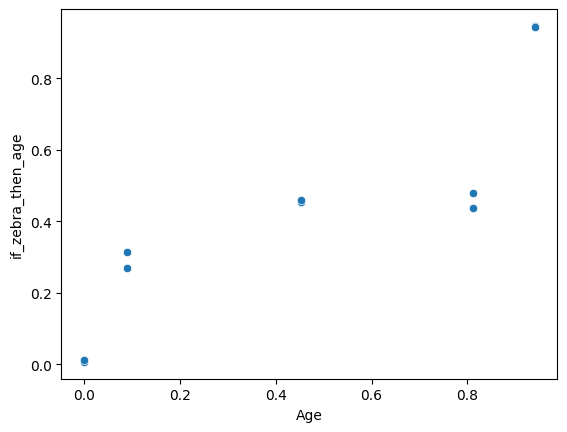

In [33]:
sns.scatterplot(
    x = showcase_df.loc[:, 'Age'],
    y = showcase_df.loc[:, 'if_zebra_then_age']
)

Text(0, 0.5, 'Feature_2')

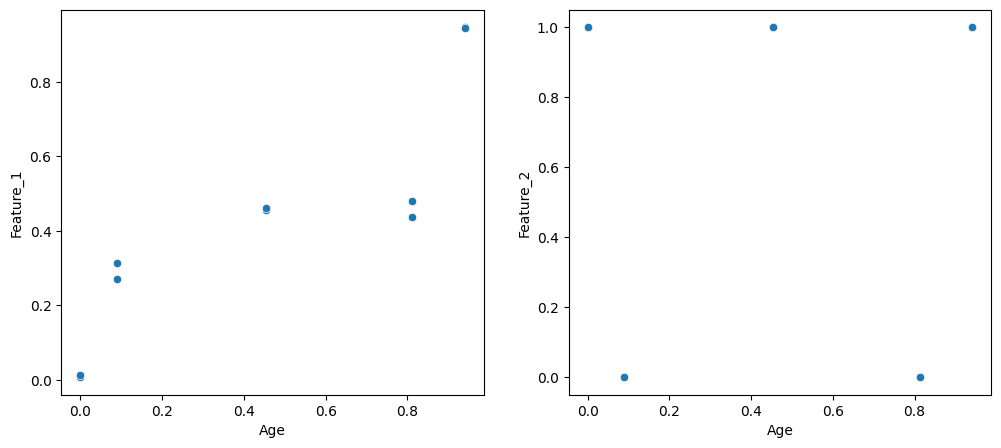

In [34]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12,5)

izta = sns.scatterplot(
    x = showcase_df.Age,
    y = showcase_df.if_zebra_then_age,
    ax = axes[0]
)

izta.set_ylabel('Feature_1')

iaz = sns.scatterplot(
    x = showcase_df.Age,
    y = showcase_df.Zebra,
    ax = axes[1]
)

iaz.set_ylabel('Feature_2')

<Axes: xlabel='Age', ylabel='if_zebra_then_age'>

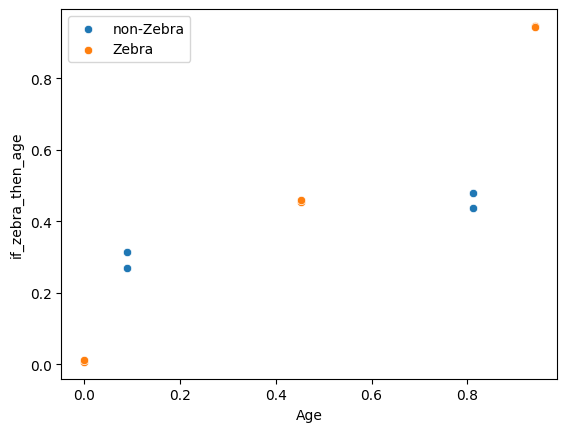

In [35]:
sns.scatterplot(
    x = showcase_df.Age[~showcase_df.Zebra],
    y = showcase_df.if_zebra_then_age[~showcase_df.Zebra],
    label='non-Zebra'
)
sns.scatterplot(
    x = showcase_df.Age[showcase_df.Zebra],
    y = showcase_df.if_zebra_then_age[showcase_df.Zebra],
    label='Zebra'
)

In [36]:
model = FeatureSelectionModel(
    dummy_explainables,
    dummy_observables,
    #df_observable,
    #observable_patterns_result['df_cluster_median'],
    observable_patterns_result['df_cluster_median'].loc[:, ['if_zebra_then_age', 'unexplainable_1']],
    num_virtual_features=1,
    power = 4.,
    index_name = 'Individual',
    num_samples = 10,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

self = model

In [38]:
# feature_weights
feature_weights = self.constrained('feature_weights')

# observation_weights
#observation_weights = self.constrained('observation_weights')
observation_weights = torch.tensor([0.999, 0.001]) # !

# cluster positions
#cluster_positions = self.constrained('cluster_positions').clamp(min = 1e-10, max=1e10)

short_cluster_positions = torch.tensor(

   [[0.0000, 0.8166],
    [1.0000, 0.5975]],

dtype=torch.float64)

medium_cluster_positions = torch.tensor(

   [[0.0000, 0.8166],
    [0.2500, 0.3059],
    [0.5000, 0.5250],
    [0.7500, 0.2543],
    [1.0000, 0.5975]],

dtype=torch.float64)

long_cluster_positions = torch.tensor(

   [[0.0000, 0.8166],
    [0.1000, 0.3059],
    [0.2000, 0.5250],
    [0.3000, 0.2543],
    [0.4000, 0.1324],
    [0.5000, 0.6552],
    [0.6000, 0.8742],
    [0.7000, 0.8943],
    [0.8000, 0.2322],
    [0.9000, 0.4211],
    [1.0000, 0.4322]],

dtype=torch.float64)

cluster_positions = medium_cluster_positions

# fingerprints
observables = self.tensor_observable
base_tensor = torch.tensor(1e-6) #self.base_tensor
sampled_fingerprints, fingerprint_variance = self.sample_fingerprints(
    observation_weights=observation_weights,
    cluster_positions=cluster_positions,
    observables=observables,
    base_tensor=base_tensor
)

# Auxiliary loss function
auxiliary_loss = -fingerprint_variance

# Construct the distance matrix for the fingerprints
fingerprint_distances = new_torch_matrix_jensenshannon(sampled_fingerprints)

# Construct the distance matrix for the features
feature_weights = (feature_weights / feature_weights.sum())
#feature_weights = feature_weights.repeat(self.tensor_explainable.shape[0], 1)
explainables = self.tensor_explainable.clone()
'''for v_i in range(self.num_virtual_features):
    antecedens, consequent, implication_loss = self.conditional(v_i)
    feature_weights[:, self.num_features + v_i] *= antecedens
    explainables = torch.hstack((explainables, consequent.unsqueeze(-1)))
    auxiliary_loss += implication_loss'''
    
feature_distances = construct_distance_matrix(
    A=explainables, feature_weights=feature_weights, normalize=False
)

# Calculate the correlation between the distance matrix and the observable distances
coef = pearson_corrcoef(feature_distances, fingerprint_distances)
coef

tensor(0.5657, dtype=torch.float64, grad_fn=<DifferentiableGraphBackward>)

In [39]:
sampled_fingerprints.numpy().round(3)

array([[0.998, 0.002, 0.   , 0.   , 0.   ],
       [0.   , 0.011, 0.988, 0.001, 0.   ],
       [0.   , 0.   , 0.   , 0.02 , 0.98 ],
       [0.   , 0.01 , 0.989, 0.001, 0.   ],
       [0.001, 0.987, 0.012, 0.   , 0.   ]])

In [40]:
(fingerprint_distances).numpy().round(3)

array([[0.   , 0.831, 0.833, 0.831, 0.826],
       [0.831, 0.   , 0.831, 0.003, 0.794],
       [0.833, 0.831, 0.   , 0.831, 0.832],
       [0.831, 0.003, 0.831, 0.   , 0.795],
       [0.826, 0.794, 0.832, 0.795, 0.   ]])

In [41]:
(fingerprint_distances / fingerprint_distances.sum()).numpy().round(3)

array([[0.   , 0.056, 0.056, 0.056, 0.056],
       [0.056, 0.   , 0.056, 0.   , 0.054],
       [0.056, 0.056, 0.   , 0.056, 0.056],
       [0.056, 0.   , 0.056, 0.   , 0.054],
       [0.056, 0.054, 0.056, 0.054, 0.   ]])

In [42]:
feature_distances.clone().detach().numpy().round(3)

array([[0.   , 0.033, 0.053, 0.063, 0.056],
       [0.033, 0.   , 0.024, 0.062, 0.07 ],
       [0.053, 0.024, 0.   , 0.042, 0.068],
       [0.063, 0.062, 0.042, 0.   , 0.029],
       [0.056, 0.07 , 0.068, 0.029, 0.   ]])

In [44]:
pearson_corrcoef(feature_distances, fingerprint_distances)

tensor(0.5657, dtype=torch.float64, grad_fn=<DifferentiableGraphBackward>)

In [45]:
zebra_filter = model.tensor_explainable[:, 2] > 0.5
zebra_filter

tensor([ True,  True,  True, False, False])

In [120]:
zebra_distances = feature_distances[zebra_filter][:, zebra_filter]
zebra_fingerprints = fingerprint_distances[zebra_filter][:, zebra_filter]

pearson_corrcoef(zebra_fingerprints, zebra_distances)

tensor(0.8641, dtype=torch.float64, grad_fn=<DifferentiableGraphBackward>)

In [127]:
###

pearson_corrcoef(zebra_fingerprints, zebra_distances)

A = feature_distances#[zebra_filter][:, zebra_filter]
B = fingerprint_distances #[zebra_filter][:, zebra_filter]
w = (zebra_filter * 1.).clamp(min=1e-20, max=1-1e-20)
ow = torch.ones(w.shape)

In [128]:
pearson_corrcoef(A, B)

tensor(0.5657, dtype=torch.float64, grad_fn=<DifferentiableGraphBackward>)

In [222]:
@torch.jit.script
def apply_weights(A, w):
    return w.unsqueeze(-1)*A*w

@torch.jit.script
def weighted_mean(A, w):
    _w = w / w.sum()
    return ((_w*A).sum(dim=1)*_w).sum()

@torch.jit.script
def weighted_pearson_corrcoef(x:torch.Tensor, y:torch.Tensor, w:torch.Tensor) -> torch.Tensor:
    '''
    Calculates the Person correlation coefficient.
    PyTorch equivalent to numpy.corrcoef(x, y)[0, 1].
    '''

    A = apply_weights(x, w)
    Am = weighted_mean(A, w)
    vx = apply_weights(A - Am, w)

    B = apply_weights(y, w)
    Bm = weighted_mean(B, w)
    vy = apply_weights(B - Bm, w)

    return torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)) + 1e-20)

In [225]:
weighted_pearson_corrcoef(A,B,w)

tensor(0.8641, dtype=torch.float64, grad_fn=<DifferentiableGraphBackward>)

In [224]:
pearson_corrcoef(zebra_fingerprints, zebra_distances)

tensor(0.8641, dtype=torch.float64, grad_fn=<DifferentiableGraphBackward>)

In [221]:
_zebra_distances = feature_distances[~zebra_filter][:, ~zebra_filter]
_zebra_fingerprints = fingerprint_distances[~zebra_filter][:, ~zebra_filter]

pearson_corrcoef(_zebra_fingerprints, _zebra_distances)

tensor(1.0000, dtype=torch.float64, grad_fn=<DifferentiableGraphBackward>)

In [625]:
v_i = 0
antecedens, consequent, implication_loss = self.conditional(v_i)

tensor([0.1710, 0.7306, 0.3287, 0.1692, 0.2010, 0.2242, 0.0380, 0.4292, 0.0000,
        0.0212, 0.2085, 0.1947, 1.0000, 0.6806, 0.5987, 0.4176, 0.0763, 0.3697,
        0.1842, 0.0235], dtype=torch.float64, grad_fn=<DivBackward0>)

In [611]:
from gradient_solver import _construct_distance_matrix

In [612]:
df_explainable = preparation_result['explainable_df'].copy().set_index(index_name)
df_observable = observable_patterns_result['df_observable_data'].copy().set_index(index_name).loc[:, observed_features].reset_index()

In [250]:
model = FeatureSelectionModel(
    df_explainable,
    df_observable.loc[:, ['Individual', 'if_zebra_then_age', 'unexplainable_1']],
    #df_observable,
    #observable_patterns_result['df_cluster_median'],
    observable_patterns_result['df_cluster_median'].loc[:, ['if_zebra_then_age', 'unexplainable_1']],
    num_virtual_features=1,
    power = 4.,
    index_name = 'Individual',
    num_samples = 10,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

# After this many steps, the learning rate is halved
HALFLIFE = 5

'''optimizer = torch.optim.RMSprop(
    params = [
        {'params': model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)'''
optimizer = torch.optim.RMSprop(lr=0.10, momentum=0.50, params=model.parameters.parameters())

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {model.loss().clone().detach()}')
print(f'Correlation before training: {model.get_coef()}')
print('')
trainer.train(epochs = 10, timeout=60000)
print('')
print(f'Correlation after training: {model.get_coef()}')

Loss before training: -0.5824301541092699
Correlation before training: 0.5482462015353685

1/10 --- Mean Loss : -0.9756368729465217
2/10 --- Mean Loss : -1.0697318224983423
3/10 --- Mean Loss : -1.0762820274505596
4/10 --- Mean Loss : -1.0767128443134786
5/10 --- Mean Loss : -1.0774070063091936
6/10 --- Mean Loss : -1.078549642709144
7/10 --- Mean Loss : -1.0787658683937122
8/10 --- Mean Loss : -1.0795604532691372
9/10 --- Mean Loss : -1.0796327898098588
10/10 --- Mean Loss : -1.079732894795471

Correlation after training: 0.9957877987576038


In [251]:
model.interpretation(0, thresh=0.05)

'[Age > 0.00] ∧ [Weight > 0.00] ∧ [Is_a_Zebra > 0.00] ∧ [Loves_to_sleep > 0.00] ∧ [Noise_1 > 0.00] ∧ [Noise_2 > 0.00] ∧ [Noise_3 > 0.00] ∧ [Noise_4 > 0.00] ∧ [Noise_5 > 0.00] ⇒ [Age > 0.00] ∧ [Weight > 0.00] ∧ [Is_a_Zebra > 0.00] ∧ [Loves_to_sleep > 0.00] ∧ [Noise_1 > 0.00] ∧ [Noise_2 > 0.00] ∧ [Noise_3 > 0.00] ∧ [Noise_4 > 0.00] ∧ [Noise_5 > 0.00]'

In [252]:
model.plot(0.05)

IndexError: index 9 is out of bounds for axis 1 with size 9

In [1130]:
model.interpretation(0, 0.05)

'[Loves_to_sleep > 0.00] ∧ [Noise_3 > 0.00] ∧ [Noise_4 > 0.00] ∧ [Noise_5 > 0.00] ⇒ [Age > 0.36]'

In [ ]:
feature_dict, observation_dict = model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    if True: #v < 0.500:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

In [ ]:
remaining_features, remaining_observations

In [ ]:
next_model = FeatureSelectionModel(
    df_explainable,
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    num_virtual_features=1,
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

# After this many steps, the learning rate is halved
HALFLIFE = 50

optimizer = torch.optim.RMSprop(lr=0.1, momentum=0.50, params=next_model.parameters.parameters())

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = next_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {next_model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

In [ ]:
def logic_string_helper(self, _weights, positions, thresh):
    _features_indices = (_weights > thresh).nonzero()[0]
    if len(_features_indices) > 0:
        _features = self.feature_names[_features_indices]
        _position = positions[_features_indices]
        _string = ''
        i = 0
        for symbol, pos in zip(_features, _position):
            if pos < 0.5:
                addendum = 'Higher('
            else:
                addendum = 'Lower('
            if i == len(_features) - 1:
                _string += f'{addendum}{symbol})'
            else:
                _string += f'{addendum}{symbol}) ∧ '
            i += 1
    else:
        _string = 'Falsum'
    return _string

def interpretation(self, v_i, thresh = 0.05):
        antecedens_positions = self.constrained(f'antecedens_positions_{v_i}').clone().detach().numpy()
        consequent_positions = self.constrained(f'consequent_positions_{v_i}').clone().detach().numpy()
        antecedens_weights   =  self.constrained(f'antecedens_weights_{v_i}').clone().detach().numpy()
        consequent_weights   = self.constrained(f'consequent_weights_{v_i}').clone().detach().numpy()

        antecedens_weights = antecedens_weights/antecedens_weights.sum()
        consequent_weights = consequent_weights/consequent_weights.sum()

        antecedens_string = logic_string_helper(self, antecedens_weights, antecedens_positions, thresh)
        consequent_string = logic_string_helper(self, consequent_weights, consequent_positions, thresh)
        interpretation_string = f'{antecedens_string} ⇒ {consequent_string}'

        return interpretation_string

In [ ]:
self = next_model

In [ ]:
interpretation(self, 0)

In [ ]:
thresh = 0.05

In [ ]:
antecedens_positions = self.constrained(f'antecedens_positions_{v_i}').clone().detach().numpy()
consequent_positions = self.constrained(f'consequent_positions_{v_i}').clone().detach().numpy()
antecedens_weights   =  self.constrained(f'antecedens_weights_{v_i}').clone().detach().numpy()
consequent_weights   = self.constrained(f'consequent_weights_{v_i}').clone().detach().numpy()

In [ ]:
antecedens_weights = antecedens_weights/antecedens_weights.sum()
consequent_weights = consequent_weights/consequent_weights.sum()

In [ ]:
antecedens_features_indices = (antecedens_weights > thresh).nonzero()[0]
if len(antecedens_features_indices) > 0:
    antecedens_features = self.feature_names[antecedens_features_indices]
    antecedens_position = antecedens_positions[antecedens_features_indices]
    antecedens_string = ''
    i = 0
    for symbol, pos in zip(antecedens_features, antecedens_position):
        if pos < 0.5:
            addendum = 'Higher('
        else:
            addendum = 'Lower('
        if i == len(antecedens_features) - 1:
            antecedens_string += f'{addendum}{symbol})'
        else:
            antecedens_string += f'{addendum}{symbol}) ∧ '
        i += 1
else:
    antecedens_string = 'Falsum'

In [ ]:
consequent_features_indices = (consequent_weights > thresh).nonzero()[0]
if len(consequent_features_indices) > 0:
    consequent_features = self.feature_names[consequent_features_indices]
    consequent_position = consequent_positions[consequent_features_indices]
    consequent_string = ''
    i = 0
    for symbol, pos in zip(consequent_features, consequent_position):
        if pos < 0.5:
            addendum = 'Higher('
        else:
            addendum = 'Lower('
        if i == len(consequent_features) - 1:
            consequent_string += f'{addendum}{symbol})'
        else:
            consequent_string += f'{addendum}{symbol}) ∧ '
        i += 1
else:
    consequent_string = 'Falsum'

In [ ]:
f'{antecedens_string} ⇒ {consequent_string}'

In [ ]:
antecedens_string = [antecedens_features]

In [ ]:
sns.barplot(antecedens_positions)

In [ ]:
sns.barplot(antecedens_weights)

In [ ]:
sns.barplot(consequent_positions)

In [ ]:
sns.barplot(consequent_weights)

In [ ]:
next_model.conditional(0)

In [ ]:
next_model.plot()

In [ ]:
feature_dict, observation_dict = next_model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    #if v < 0.500:
    if True:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

remaining_features, remaining_observations

In [ ]:
next2_model = FeatureSelectionModel(
    df_explainable,#.loc[:, remaining_features],
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    num_virtual_features=1,
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

my_model = next2_model

# After this many steps, the learning rate is halved
HALFLIFE = 30

optimizer = torch.optim.RMSprop(
    params = [
        {'params': my_model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = my_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {my_model.loss().clone().detach()}')
trainer.train(epochs = 100, timeout=60000)

In [ ]:
next2_model.plot()

In [ ]:
feature_dict, observation_dict = next2_model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    if v < 0.500:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

remaining_features, remaining_observations

In [ ]:
next3_model = FeatureSelectionModel(
    df_explainable.loc[:, remaining_features],
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

my_model = next3_model

# After this many steps, the learning rate is halved
HALFLIFE = 30

optimizer = torch.optim.RMSprop(
    params = [
        {'params': my_model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = my_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {my_model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

In [ ]:
next3_model.plot()

In [ ]:
...